## Обзор моделей кластеризации

### Цель

    Осмотреть некоторые алгоритмы машинного обучения в задаче кластеризации.
    Посмотреть на эффективность данных моделей.
    Изучить влияние разных методов векторизации: слова, н-граммы из слов, н-граммы из букв.
    Изучить влияние понижения размерности разряженных матриц при работе с текстовыми данными.
    Если получится хорошо кластеризировать данные - составить список категорий, где кластеры данных находятся на максимальном расстоянии друг от друга.

### Данные

Набор данных представлен записями сделанными пользователями с Толоки.

    entry - запись о трате сделанная пользователем
    category - одна из базовых категорий, определены пользователями
    confidence - уверенность в ответе пользователей после агрегации по методу Дэвида-Скина
    
### Базовые категории

Ранее присвоенные пользователями категории.

<details>
<summary>Кликни чтобы раскрыть список.</summary>

Housing:

    Rent or mortgage payments, property taxes, HOA dues, and home repair & maintenance costs.

Transportation:

    Car payments, registration and DMV fees, gas, maintenance, parking, tolls, and public transit.

Groceries & Dining:

    Groceries,  dining out, work lunches, food delivery, baby food, pet food etc.

Utilities & Phone:

    Water, electricity, gas and sewage bills. Cell phone, cable, and internet expenses. Streaming services and subscriptions.

Medical & Healthcare:

    Out-of-pocket costs for primary care, specialty care (dermatologists, psychologists, etc.), dental care, urgent care, prescriptions etc.

Recreation & Entertainment:

    Concert & sporting tickets, family activities & vacations, gifts.

Personal:

    Gym memberships, clothes and shoes, beauty treatments, hobbies.

Saving & Debt:

    Credit card bills, personal loans, or student loans. Investing and saving of all kind.

Miscellaneous:

    All that is clearly some expense but doesn't fit into main categories.

Entry is incomprehensible (категория `nonsense`):

    Please mark this option if an expense note is not understandable.
    
</details>

## EDA

Установим дополнительную библиотеку pandas_profiling для EDA и библиотеку LightGBM.

In [1]:
!pip install pandas_profiling -q

Загрузка необходимых модулей.

In [2]:
import pandas as pd
import numpy as np
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

import nltk
import re
from nltk.corpus import stopwords

#nltk.download("stopwords") # поддерживает удаление стоп-слов
#nltk.download('punkt') # делит текст на список предложений
#nltk.download('wordnet') # проводит лемматизацию

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from sklearn.cluster import DBSCAN

Зададим глобальные переменные.

In [3]:
SEED = 31416

Загрузим датасет и осмотрим данные.

In [4]:
df = pd.read_csv('toloka_df.csv', index_col='Unnamed: 0')
df.drop(columns='confidence', inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11550 entries, 0 to 11549
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   entry     11550 non-null  object
 1   category  11550 non-null  object
dtypes: object(2)
memory usage: 270.7+ KB


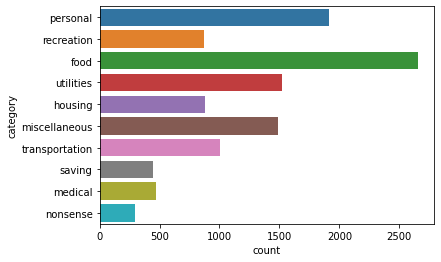

In [6]:
sns.countplot(data=df, y='category')
plt.show()

In [7]:
df.profile_report().to_file('toloka_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Сбросим полные дубликаты чтобы убрать bias.

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9497 entries, 0 to 11549
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   entry     9497 non-null   object
 1   category  9497 non-null   object
dtypes: object(2)
memory usage: 222.6+ KB


## Предобработка текста

Добавим дополнительные слова в наш стоп-лист.

In [10]:
new_stopwords = [
    'buy', 'bought', 'new', 'fee', 'purchase', 'dollar', 'expense',
    'take', 'mom', 'dad', 'mum', 'help', 'payment'
]
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(new_stopwords)

Очистим и лемматизируем наши тексты.

In [11]:
lemmatize = nltk.WordNetLemmatizer()

def cleaning(row):
    text = re.sub('[^a-zA-Z]', ' ', row.entry).lower() # удаляем неалфавитные символы, приводим к нижнему регистру
    text = nltk.word_tokenize(text, language = 'english') # токенизируем слова
    text = [lemmatize.lemmatize(word) for word in text] # лемматирзируем слова
    text = [word for word in text if not word in stpwrd] # фильтруем слова
    row['entry_new'] = ' '.join(text) # соединяем слова
    return row

Создадим столбец с очищенными леммами.

In [12]:
df = df.apply(cleaning, axis=1)

Посмотрим на результат.

In [13]:
df.sample(5)

,entry,category,entry_new
8892,New Phone,miscellaneous,phone
4897,Car fuel 20 bucks,transportation,car fuel buck
8073,Strawberry jam,food,strawberry jam
6239,eyelashes,personal,eyelash
8786,Buy Cat food,food,cat food


Создадим объекты векторизатора, обучим и применим к новому столбцу стратегию "TF-IDF".

In [14]:
vectorizer_w = TfidfVectorizer(stop_words="english", analyzer='word', ngram_range=(1,3))
vectorizer = TfidfVectorizer(stop_words="english", analyzer='word', ngram_range=(1,1))
vectorizer_c = TfidfVectorizer(stop_words="english", analyzer='char_wb', ngram_range=(3,5))
X_w = vectorizer_w.fit_transform(df.entry_new)
X = vectorizer.fit_transform(df.entry_new)
X_c = vectorizer_c.fit_transform(df.entry_new)

## Работа с моделями

### K-means

Проверим кластеризатор Kmeans. Для своей работы он требует указание количества классов, сначала проверим результат на ранее выбранном количестве.

In [15]:
%%time
clusters = 10

minibatch_kmeans_w = MiniBatchKMeans(n_clusters=clusters, random_state=SEED)
labels_w = minibatch_kmeans_w.fit_predict(X_w)
minibatch_kmeans = MiniBatchKMeans(n_clusters=clusters, random_state=SEED)
labels = minibatch_kmeans.fit_predict(X)
minibatch_kmeans_c = MiniBatchKMeans(n_clusters=clusters, random_state=SEED)
labels_c = minibatch_kmeans_c.fit_predict(X_c)

CPU times: total: 516 ms
Wall time: 426 ms


Сравним присвоенные значения с теми что были присвоены людьми.

In [16]:
df['new_w'] = labels_w
df['new'] = labels
df['new_c'] = labels_c

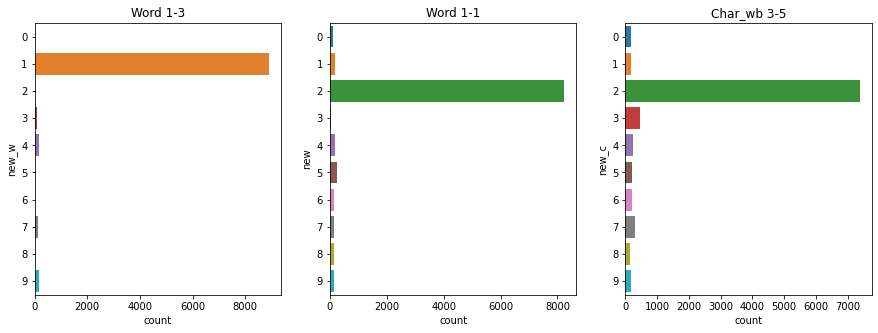

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(data=df, y='new_w', ax=ax1)
ax1.set_title('Word 1-3')
sns.countplot(data=df, y='new', ax=ax2)
ax2.set_title('Word 1-1')
sns.countplot(data=df, y='new_c', ax=ax3)
ax3.set_title('Char_wb 3-5')
plt.show()

Виден большой дисбаланс по классам, проверим ключевые слова в кластерах.

In [18]:
order_centroids = minibatch_kmeans_c.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer_c.get_feature_names()

for i in range(clusters):
    print(f'Cluster {i}: ', end='')
    for ind in order_centroids[i, :10]:
        print(f'{terms[ind]} ', end='')
    print()

Cluster 0: ance  ance anc nce  nce  insu insu nsur nsura uranc 
Cluster 1:  food food food  ood  foo foo ood  od   fo  dog 
Cluster 2: er  ing ng  ing   ca nt  ent  re car  car 
Cluster 3: ill  bill   bill  bil bill ill bil ll   bi ter 
Cluster 4: hone  phone phon hone pho hon one  one  phon  pho 
Cluster 5: gift  ift   gif  gift gif gift ift ft   gi day  
Cluster 6:  sho sho  sh shoe   shoe hoe hoe  shoe oe  hoppi 
Cluster 7: ion  ion tion  tion tio on  scri crip ript cript 
Cluster 8:  ba baby  baby aby  bab bab baby  aby  by   bag  
Cluster 9: chool schoo  scho choo scho  sch hool sch hoo hool  


In [19]:
for i in range(clusters):
    print(f'Cluster {i}: ', end='')
    category_counts = df[df.new_c == i].category.value_counts()[:5]
    for name, count in zip(category_counts.index, category_counts):
        print(f'{name} - {count}, ', end='')
    print()

Cluster 0: transportation - 52, medical - 42, housing - 30, saving - 26, miscellaneous - 9, 
Cluster 1: food - 164, miscellaneous - 11, nonsense - 1, housing - 1, saving - 1, 
Cluster 2: food - 1715, personal - 1388, miscellaneous - 1130, housing - 665, transportation - 644, 
Cluster 3: utilities - 349, medical - 26, food - 19, housing - 14, transportation - 13, 
Cluster 4: utilities - 212, miscellaneous - 21, personal - 4, recreation - 4, saving - 4, 
Cluster 5: recreation - 121, miscellaneous - 40, personal - 17, food - 14, nonsense - 10, 
Cluster 6: personal - 124, food - 58, miscellaneous - 22, housing - 7, recreation - 6, 
Cluster 7: utilities - 126, transportation - 43, recreation - 40, miscellaneous - 30, personal - 24, 
Cluster 8: personal - 53, miscellaneous - 45, food - 32, recreation - 8, medical - 5, 
Cluster 9: miscellaneous - 82, saving - 32, personal - 31, transportation - 16, food - 9, 


По ключевым словам видно что модель в случае со слогами смогла уловить схожие черты слов, но не смысл. Дисбаланс по классам не даёт нам возможность применять такую модель. Причина сильного дисбаланса при анализе текстов известна. Начальная точка центроидов в разряженных матрицах часто попадает в границах одного кластера, что приводит к сильному дисбалансу. Исправить можно понижением размерности.

Выберем новые размерности так, чтобы они объясняли не менее 95% дисперсии исходных данных.

In [20]:
x_w = 5000
х = 2000
x_c = 1750

In [21]:
lsa_w = make_pipeline(TruncatedSVD(n_components=x_w), Normalizer(copy=False))
lsa = make_pipeline(TruncatedSVD(n_components=х), Normalizer(copy=False))
lsa_c = make_pipeline(TruncatedSVD(n_components=x_c), Normalizer(copy=False))
t0 = time()
X_lsa_w = lsa_w.fit_transform(X_w)
X_lsa = lsa.fit_transform(X)
X_lsa_c = lsa_c.fit_transform(X_c)
explained_variance_w = lsa_w[0].explained_variance_ratio_.sum()
explained_variance = lsa[0].explained_variance_ratio_.sum()
explained_variance_c = lsa_c[0].explained_variance_ratio_.sum()

print(f'LSA done in {time() - t0:.3f} s')
print(f'Explained variance of the SVD step Word 1-3: {explained_variance_w * 100:.1f}%')
print(f'Explained variance of the SVD step Word 1-1: {explained_variance * 100:.1f}%')
print(f'Explained variance of the SVD step Char 3-5: {explained_variance_c * 100:.1f}%')

LSA done in 207.029 s
Explained variance of the SVD step Word 1-3: 96.7%
Explained variance of the SVD step Word 1-1: 95.3%
Explained variance of the SVD step Char 3-5: 95.6%


In [22]:
%%time
clusters = 10

minibatch_kmeans_w = MiniBatchKMeans(n_clusters=clusters, random_state=SEED)
labels_w = minibatch_kmeans_w.fit_predict(X_lsa_w)
minibatch_kmeans = MiniBatchKMeans(n_clusters=clusters, random_state=SEED)
labels = minibatch_kmeans.fit_predict(X_lsa)
minibatch_kmeans_c = MiniBatchKMeans(n_clusters=clusters, random_state=SEED)
labels_c = minibatch_kmeans_c.fit_predict(X_lsa_c)

CPU times: total: 4.05 s
Wall time: 2.25 s


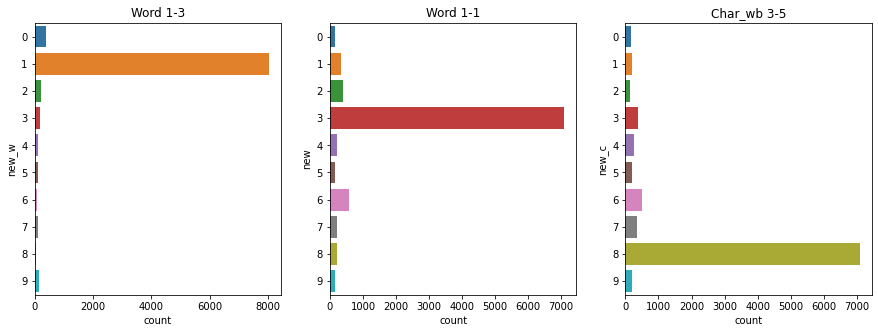

In [23]:
df['new_w'] = labels_w
df['new'] = labels
df['new_c'] = labels_c

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(data=df, y='new_w', ax=ax1)
ax1.set_title('Word 1-3')
sns.countplot(data=df, y='new', ax=ax2)
ax2.set_title('Word 1-1')
sns.countplot(data=df, y='new_c', ax=ax3)
ax3.set_title('Char_wb 3-5')
plt.show()

Посмотрим на ключевые слова.

In [24]:
original_space_centroids = lsa[0].inverse_transform(minibatch_kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(clusters):
    print(f'Cluster {i}: ', end='')
    for ind in order_centroids[i, :10]:
        print(f'{terms[ind]} ', end='')
    print()

Cluster 0: shopping nail grocery polish naira ksh clothes house monthly carefour 
Cluster 1: school food cat dog pet supply kid child son book 
Cluster 2: car insurance fuel health egg maintenance rental life wash renewal 
Cluster 3: gift hair internet gas book lunch service baby house monthly 
Cluster 4: phone case cell mobile charger repair airtime cover screen plan 
Cluster 5: water bottle bottled drinking pipe electricity mineral utility sparkling ksh 
Cluster 6: shoe birthday repair buying kid fuel cake paper present gift 
Cluster 7: electricity rent house month ksh monthly paid car pay apartment 
Cluster 8: grocery ticket store credit airtime movie card concert food flight 
Cluster 9: subscription netflix tv monthly cable gym spotify internet disney amazon 


In [25]:
for i in range(clusters):
    print(f'Cluster {i}: ', end='')
    category_counts = df[df.new == i].category.value_counts()[:5]
    for name, count in zip(category_counts.index, category_counts):
        print(f'{name} - {count}, ', end='')
    print()

Cluster 0: personal - 53, food - 52, miscellaneous - 17, housing - 6, nonsense - 3, 
Cluster 1: food - 159, miscellaneous - 90, personal - 31, saving - 30, transportation - 16, 
Cluster 2: transportation - 285, medical - 38, saving - 32, miscellaneous - 12, housing - 9, 
Cluster 3: food - 1563, personal - 1397, miscellaneous - 1156, recreation - 617, utilities - 576, 
Cluster 4: utilities - 181, miscellaneous - 16, saving - 4, nonsense - 3, personal - 2, 
Cluster 5: utilities - 82, food - 35, miscellaneous - 8, housing - 8, nonsense - 5, 
Cluster 6: personal - 151, recreation - 110, miscellaneous - 98, food - 77, housing - 65, 
Cluster 7: housing - 104, utilities - 92, transportation - 14, nonsense - 2, saving - 2, 
Cluster 8: food - 124, recreation - 49, transportation - 22, miscellaneous - 1, nonsense - 1, 
Cluster 9: utilities - 120, recreation - 21, personal - 8, miscellaneous - 4, transportation - 2, 


Из распределения ответов кластеризатора видно что ответы модели сильно отличаются от ответов людей. Только 7 категория совпала почти полностью с исходной `utilities`.

Для кластеризатора K-means есть метод определения оптимального количества кластеров - "метод локтя". Он заключается в итеративном нахождении инерции (сумма квадратов дистанций от образца до центра кластера) и вычерчивания графика количество_кластеров - инерция. Излом на графике показывает оптимальное количество кластеров.

In [26]:
%%time
inertia = []
for k in tqdm(range(1, 100), 'progress'):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=SEED).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

progress: 100%|████████████████████████████████████████████████████████████████████████| 99/99 [00:21<00:00,  4.58it/s]

CPU times: total: 29.5 s
Wall time: 21.6 s


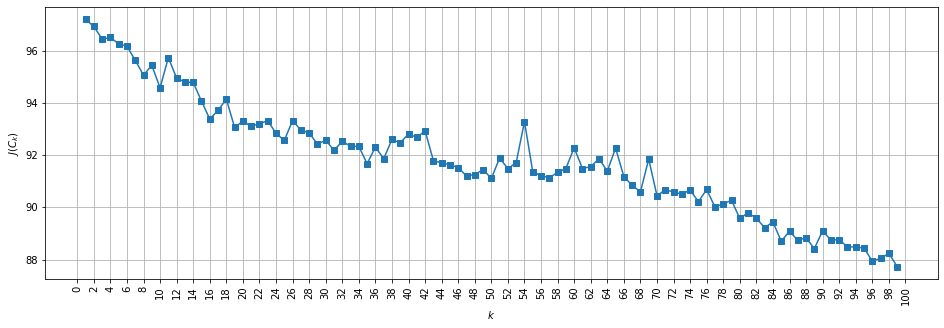

In [27]:
fig = plt.figure(figsize=(16, 5))
plt.plot(range(1, 100), inertia[:99], marker="s")
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')
plt.xticks(np.arange(0, 101, 2), rotation=90)
plt.grid()
plt.show()

То же самое но для датасета с уменьшенной размерностью, из n-грам.

In [28]:
%%time
inertia = []
for k in tqdm(range(1, 100), 'progress'):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=SEED).fit(X_lsa_c)
    inertia.append(np.sqrt(kmeans.inertia_))

progress: 100%|████████████████████████████████████████████████████████████████████████| 99/99 [01:15<00:00,  1.31it/s]

CPU times: total: 2min 57s
Wall time: 1min 15s


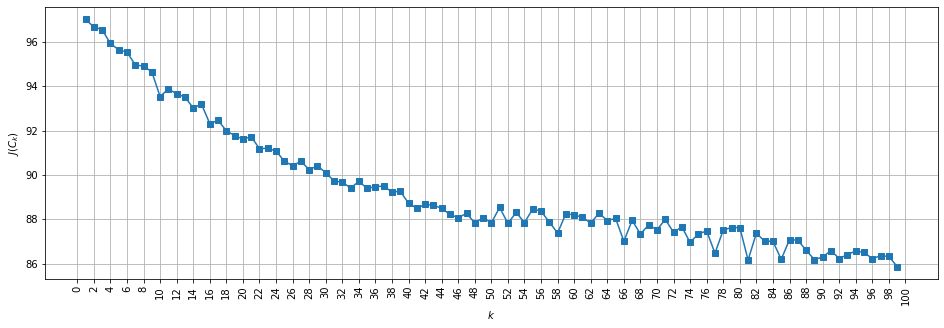

In [29]:
fig = plt.figure(figsize=(16, 5))
plt.plot(range(1, 100), inertia[:99], marker="s")
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')
plt.xticks(np.arange(0, 101, 2), rotation=90)
plt.grid()
plt.show()

К сожалению, мы видим что значения инерции далеки от 0. Ни оригинальные данные, ни данные с уменьшением размерности не подходят близко к оси J=0 (что говорит о невозможности однозначно разделить кластера, они сильно пересекаются). На данных видны изломы на 16 кластерах, проверим эту точку.

In [30]:
%%time
clusters = 16

minibatch_kmeans_w = MiniBatchKMeans(n_clusters=clusters, random_state=SEED)
labels_w = minibatch_kmeans_w.fit_predict(X_lsa_w)
minibatch_kmeans = MiniBatchKMeans(n_clusters=clusters, random_state=SEED)
labels = minibatch_kmeans.fit_predict(X_lsa)
minibatch_kmeans_c = MiniBatchKMeans(n_clusters=clusters, random_state=SEED)
labels_c = minibatch_kmeans_c.fit_predict(X_lsa_c)

CPU times: total: 4.88 s
Wall time: 2.37 s


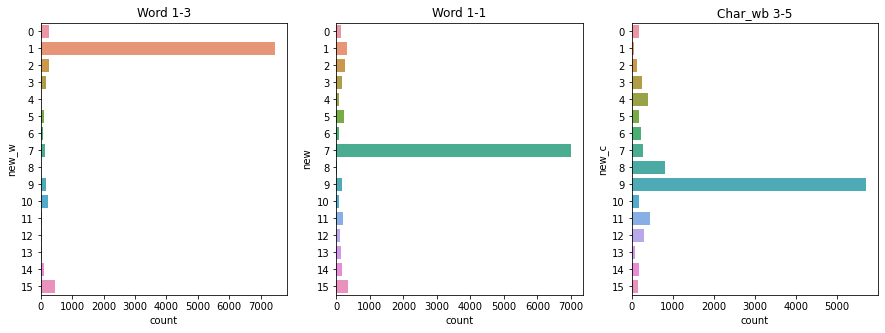

In [31]:
df['new_w'] = labels_w
df['new'] = labels
df['new_c'] = labels_c

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(data=df, y='new_w', ax=ax1)
ax1.set_title('Word 1-3')
sns.countplot(data=df, y='new', ax=ax2)
ax2.set_title('Word 1-1')
sns.countplot(data=df, y='new_c', ax=ax3)
ax3.set_title('Char_wb 3-5')
plt.show()

Посмотрим на ключевые слова.

In [32]:
original_space_centroids = lsa_w[0].inverse_transform(minibatch_kmeans_w.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer_w.get_feature_names()

for i in range(clusters):
    print(f'Cluster {i}: ', end='')
    for ind in order_centroids[i, :7]:
        print(f'{terms[ind]} ', end='')
    print()

Cluster 0: shopping transport cable fuel fare notebook taxi 
Cluster 1: hair book gas subscription repair house ticket 
Cluster 2: car fuel car fuel car wash wash fuel car car rental 
Cluster 3: school kid school kid school supply son book supply 
Cluster 4: sugar tin sugar tin sugar kg buying sugar cup sugar white sugar 
Cluster 5: insurance car insurance car health insurance health life life insurance 
Cluster 6: internet internet bundle bundle internet subscription internet ksh internet service subscription 
Cluster 7: grocery grocery shopping shopping grocery store store grocery shopping ksh shopping ksh 
Cluster 8: gasoline car gasoline gasoline car car jewellery girlfriend farm equipment gasoline farm 
Cluster 9: food dog dog food cat cat food pet pet food 
Cluster 10: shoe tuition laundry toothpaste mobile vacation rice 
Cluster 11: lunch restaurant school lunch lunch box lunch restaurant box lunch family 
Cluster 12: clothes baby clothes clothes amazon baby amazon clothes child

In [33]:
for i in range(clusters):
    print(f'Cluster {i}: ', end='')
    category_counts = df[df.new_w == i].category.value_counts()[:5]
    for name, count in zip(category_counts.index, category_counts):
        print(f'{name} - {count}, ', end='')
    print()

Cluster 0: transportation - 130, utilities - 41, miscellaneous - 27, personal - 25, food - 22, 
Cluster 1: food - 1519, personal - 1435, miscellaneous - 1200, recreation - 769, housing - 694, 
Cluster 2: transportation - 236, saving - 4, miscellaneous - 3, housing - 2, personal - 1, 
Cluster 3: miscellaneous - 76, personal - 30, saving - 28, transportation - 11, nonsense - 6, 
Cluster 4: food - 13, miscellaneous - 1, 
Cluster 5: medical - 37, transportation - 31, saving - 24, miscellaneous - 7, housing - 6, 
Cluster 6: utilities - 76, 
Cluster 7: food - 126, 
Cluster 8: transportation - 9, medical - 1, 
Cluster 9: food - 148, miscellaneous - 10, nonsense - 1, housing - 1, saving - 1, 
Cluster 10: personal - 128, miscellaneous - 43, saving - 10, food - 8, nonsense - 6, 
Cluster 11: food - 39, personal - 1, nonsense - 1, miscellaneous - 1, recreation - 1, 
Cluster 12: personal - 20, miscellaneous - 2, 
Cluster 13: food - 17, housing - 1, 
Cluster 14: food - 84, utilities - 19, recreation

#### Выводы

Мы рассмотрели самый популярный алгоритм кластеризации K-Means.

При применении на разряженных данных (текст) мы столкнулись с известной проблемой инициализации координат центроидов, которую получилось частично решить с помощью понижения размерности (LSA).

Построили графики зависимости инерции от количества кластеров, но, к сожалению, даже по ним видно что кластера получаются с сильным наложением. Ни исходное количество кластеров 10, ни излом найденный на графике инерции - 16 кластеров не дают хорошего разделения и возможности идентифицировать категории.

Т.о. можно заключить что разделение основанное на случайном выборе положения центроидов и последующей коррекции не позволяет хорошо разделить наши данные. Попробуем другие подходы.

### Agglomerative clustering

Другим подходом к определению кластеров является Agglomerative clustering. Суть его в том что изначально каждый объект в датасете становится отдельным кластером, далее после сортировки по взаимному расстоянию между парами кластеров мы объединяем ближайшие пары кластеров в родительский кластер и т.д.

Попробуем стратегию с полной связью - максимальная дистанция между всеми вхождениями двух кластеров.

In [34]:
%%time
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, compute_distances=True, linkage='complete')
model = model.fit(X.toarray())

CPU times: total: 1min 27s
Wall time: 1min 27s


In [35]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

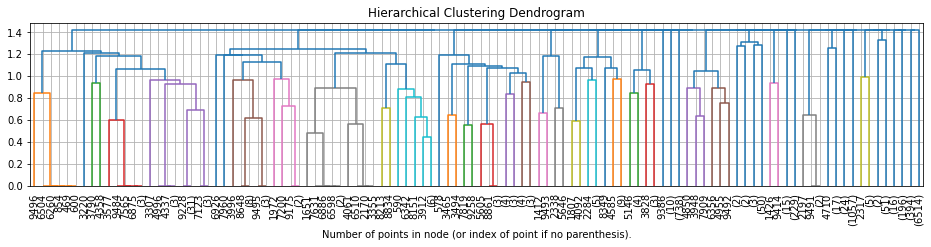

In [36]:
fig = plt.figure(figsize=(16, 3))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', orientation='top', p=8, leaf_font_size=10)
plt.xlabel('Number of points in node (or index of point if no parenthesis).')
plt.grid()
plt.show()

По дендрограмме видно, что даже при количестве кластеров больше 100, основная часть данных (6514) всё ещё не разделена и находится в отдельной ветке. Попробуем с уменьшенными размерностями.

In [37]:
%%time
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, compute_distances=True, linkage='complete')
model = model.fit(X_lsa_w)

CPU times: total: 2min 20s
Wall time: 2min 20s


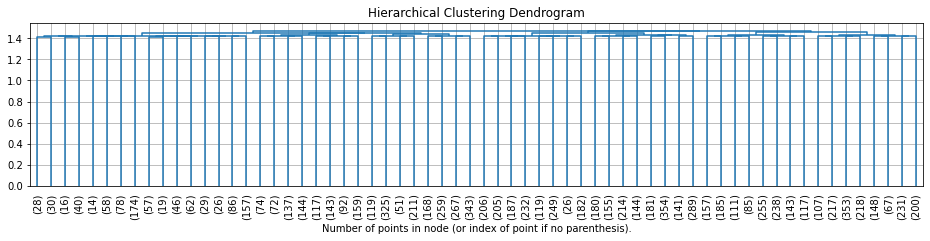

In [38]:
fig = plt.figure(figsize=(16, 3))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', orientation='top', p=5, leaf_font_size=10)
plt.xlabel('Number of points in node (or index of point if no parenthesis).')
plt.grid()
plt.show()

Данные распределены лучше, посмотрим на качество.

In [39]:
%%time
model = AgglomerativeClustering(distance_threshold=1.425, n_clusters=None, compute_distances=True, linkage='complete')
labels = model.fit_predict(X_lsa_w)

CPU times: total: 2min 18s
Wall time: 2min 18s


In [40]:
model.n_clusters_

15

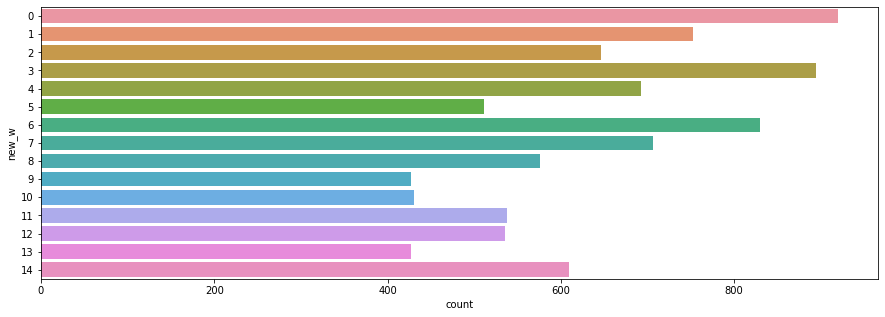

In [41]:
df['new_w'] = labels

fig = plt.figure(figsize=(15, 5))
sns.countplot(data=df, y='new_w')
plt.show()

Посмотрим на ключевые слова и категории.

In [42]:
for i in range(model.n_clusters_):
    print(f'Cluster {i}: ', end='')
    category_counts = df[df.new_w == i].category.value_counts()[:5]
    for name, count in zip(category_counts.index, category_counts):
        print(f'{name} - {count}, ', end='')
    print()

Cluster 0: food - 246, personal - 165, utilities - 150, miscellaneous - 114, recreation - 69, 
Cluster 1: miscellaneous - 186, food - 129, recreation - 101, personal - 100, utilities - 70, 
Cluster 2: food - 174, personal - 137, miscellaneous - 100, utilities - 64, recreation - 36, 
Cluster 3: food - 150, miscellaneous - 144, personal - 141, housing - 113, utilities - 110, 
Cluster 4: food - 212, miscellaneous - 108, recreation - 92, personal - 78, utilities - 59, 
Cluster 5: personal - 104, transportation - 69, housing - 66, utilities - 64, food - 55, 
Cluster 6: food - 158, transportation - 125, personal - 106, miscellaneous - 101, housing - 94, 
Cluster 7: utilities - 224, personal - 99, miscellaneous - 85, food - 75, transportation - 62, 
Cluster 8: food - 160, personal - 126, miscellaneous - 75, recreation - 50, housing - 49, 
Cluster 9: personal - 74, food - 73, medical - 66, miscellaneous - 55, transportation - 50, 
Cluster 10: food - 94, personal - 86, miscellaneous - 76, savin

In [43]:
df[df.new_w == 6].sample(10)

,entry,category,entry_new,new_w,new,new_c
806,Ice-cream is 6000 naira,food,ice cream naira,6,7,9
2620,workers in the cottage,housing,worker cottage,6,7,9
10446,Buy a new dog collar,miscellaneous,dog collar,6,7,9
7528,pantalon,nonsense,pantalon,6,7,9
2641,Paid mortgage,housing,paid mortgage,6,7,9
2826,Zip lining,recreation,zip lining,6,7,8
7944,house cleaning,housing,house cleaning,6,7,8
8937,Necktie,miscellaneous,necktie,6,7,9
6784,Fabric conditioner,food,fabric conditioner,6,7,4
4218,Utilities,utilities,utility,6,7,9


К сожалению, даже на редких категориях не прослеживается логическая связь между объектами в кластерах. Попробуем альтернативную связь для оценки внутри алгоритма. `ward` старается минимизировать дисперсию внутри дочернего кластера при объединении двух родительских кластеров.

In [44]:
%%time
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, compute_distances=True, linkage='ward')
model = model.fit(X.toarray())

CPU times: total: 1min 30s
Wall time: 1min 30s


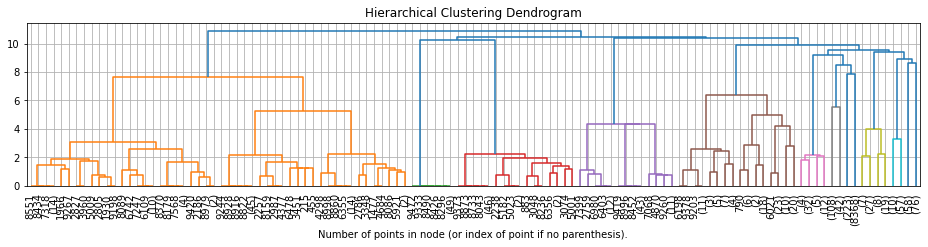

In [45]:
fig = plt.figure(figsize=(16, 3))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', orientation='top', p=7, leaf_font_size=10)
plt.xlabel('Number of points in node (or index of point if no parenthesis).')
plt.grid()
plt.show()

С данным способом объединения кластеров мы видим аналогичную проблему - бОльшая часть данных (8368) строк попали в один кластер, что говорит о близости этих векторов и для этой меры также. Попробуем также поработать с пониженными размерностями.

In [46]:
%%time
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, compute_distances=True, linkage='ward')
model = model.fit(X_lsa_c)

CPU times: total: 52.3 s
Wall time: 52.5 s


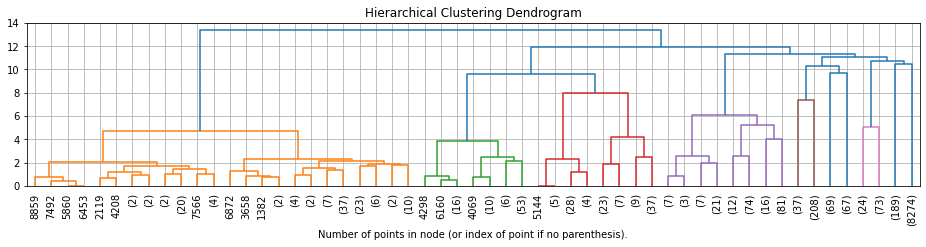

In [47]:
fig = plt.figure(figsize=(16, 3))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', orientation='top', p=5, leaf_font_size=10)
plt.xlabel('Number of points in node (or index of point if no parenthesis).')
plt.grid()
plt.show()

Подберём "разумное" количество кластеров.

In [48]:
%%time
model = AgglomerativeClustering(distance_threshold=7, n_clusters=None, compute_distances=True, linkage='ward')
labels = model.fit_predict(X_lsa_c)

CPU times: total: 53.9 s
Wall time: 54.3 s


In [49]:
model.n_clusters_

32

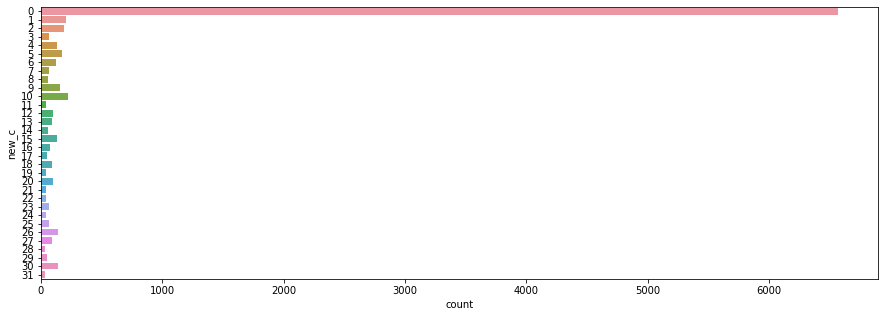

In [50]:
df['new_c'] = labels

fig = plt.figure(figsize=(15, 5))
sns.countplot(data=df, y='new_c')
plt.show()

Посмотрим на ключевые слова и категории.

In [51]:
for i in range(model.n_clusters_):
    print(f'Cluster {i}: ', end='')
    category_counts = df[df.new_c == i].category.value_counts()[:5]
    for name, count in zip(category_counts.index, category_counts):
        print(f'{name} - {count}, ', end='')
    print()

Cluster 0: food - 1590, personal - 1297, miscellaneous - 1093, recreation - 582, housing - 520, 
Cluster 1: utilities - 162, miscellaneous - 19, recreation - 5, saving - 5, personal - 4, 
Cluster 2: transportation - 56, personal - 36, miscellaneous - 34, housing - 34, utilities - 10, 
Cluster 3: medical - 67, 
Cluster 4: transportation - 57, utilities - 34, food - 28, miscellaneous - 4, housing - 2, 
Cluster 5: housing - 87, transportation - 29, utilities - 19, saving - 11, nonsense - 8, 
Cluster 6: personal - 73, housing - 22, utilities - 11, transportation - 9, miscellaneous - 8, 
Cluster 7: personal - 57, miscellaneous - 10, nonsense - 2, medical - 1, 
Cluster 8: food - 59, transportation - 1, nonsense - 1, recreation - 1, 
Cluster 9: recreation - 86, miscellaneous - 26, food - 18, personal - 16, saving - 4, 
Cluster 10: utilities - 145, recreation - 36, personal - 13, miscellaneous - 13, medical - 6, 
Cluster 11: food - 13, personal - 13, miscellaneous - 11, housing - 6, nonsense -

In [52]:
df[df.new_c == 24].sample(10)

,entry,category,entry_new,new_w,new,new_c
7217,school lunch 2000 tl,food,school lunch tl,0,10,24
763,Lunch 450,food,lunch,0,10,24
2793,Kids lunch box $7,food,kid lunch box,12,10,24
8505,Lunch 600,food,lunch,0,10,24
3075,Paid for son's lunch,personal,paid son lunch,11,10,24
8740,Lunch 3,food,lunch,0,10,24
3643,Lunch 200,food,lunch,0,10,24
3542,Lunch expenses of the month,food,lunch month,0,10,24
8044,lunchwithgf,food,lunchwithgf,11,7,24
7776,Lunch out ksh1600,food,lunch ksh,0,10,24


#### Выводы

Алгоритм Agglomerate Clustering позволяет увидеть визуальное распределение кластеров и пути их объединения с помощью дендрограмм и представляет интересный инструмент для исследования возможных кластеров.

В случае с нашими данными наиболее популярный способ поиска родительских кластеров для объединения `ward` не позволяет отделить бОльшую часть данных. Связь на основе максимальной дистанции между объединяемыми кластерами `complete` позволяет равномерно разделить данные, но полученные таким образом кластеры не имеют смысла с точки зрения "бизнес"-задачи.

Рассмотрим модель DBSCAN.

### DBSCAN

Принцип работы основан на поиске зон с высокой и низкой плотностью точек. Посмотрим на работу алгоритма на исходных данных.

In [53]:
%%time
model = DBSCAN(eps=.1, min_samples=25, metric='euclidean', n_jobs=-1)
labels = model.fit_predict(X.toarray())

CPU times: total: 36.7 s
Wall time: 7.3 s


In [54]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

10

Посмотрим на отчёт по классификации.

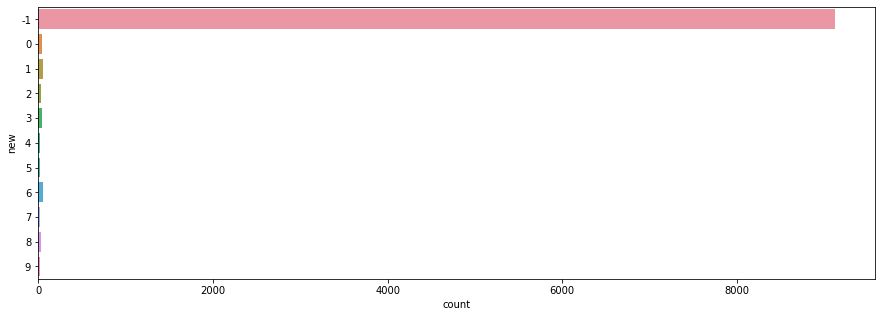

In [55]:
df['new'] = labels

fig = plt.figure(figsize=(15, 5))
sns.countplot(data=df, y='new')
plt.show()

Посмотрим на ключевые слова и категории.

In [56]:
for i in range(n_clusters_):
    print(f'Cluster {i}: ', end='')
    category_counts = df[df['new'] == i].category.value_counts()[:5]
    for name, count in zip(category_counts.index, category_counts):
        print(f'{name} - {count}, ', end='')
    print()

Cluster 0: food - 49, 
Cluster 1: utilities - 50, 
Cluster 2: transportation - 36, 
Cluster 3: utilities - 43, personal - 1, housing - 1, miscellaneous - 1, 
Cluster 4: personal - 25, recreation - 1, 
Cluster 5: housing - 24, utilities - 1, transportation - 1, 
Cluster 6: utilities - 46, food - 4, housing - 3, nonsense - 1, 
Cluster 7: transportation - 15, utilities - 11, 
Cluster 8: utilities - 32, 
Cluster 9: miscellaneous - 13, saving - 9, utilities - 3, personal - 1, 


In [57]:
df[df['new'] == 3].sample(10)

,entry,category,entry_new,new_w,new,new_c
10122,Phone bill 77,utilities,phone bill,7,3,1
8158,phone top up,utilities,phone top,7,3,1
917,phone 25,utilities,phone,7,3,1
133,Phone bill,utilities,phone bill,7,3,1
1540,Phone Bill,utilities,phone bill,7,3,1
1375,Phone bill,utilities,phone bill,7,3,1
3013,Phone,utilities,phone,7,3,1
9201,New phone 3000,utilities,phone,7,3,1
2161,New phone payment,utilities,phone,7,3,1
7128,Phone bill 25,utilities,phone bill,7,3,1


С метрикой в виде Евклидова расстояния модель записывает неразделимое облако точек в категорию `шум` или -1, остальные же категории оказались хорошо разделены и легко интерпретируемы, хотя мы и потеряли бОльшую часть данных. Попробуем провести аналогичный тест с данными уменьшенной размерности.

In [58]:
%%time
model = DBSCAN(eps=.1, min_samples=25, metric='euclidean', n_jobs=-1)
labels = model.fit_predict(X_lsa_c)

CPU times: total: 22.2 s
Wall time: 4.98 s


In [59]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

7

Посмотрим на отчёт по классификации.

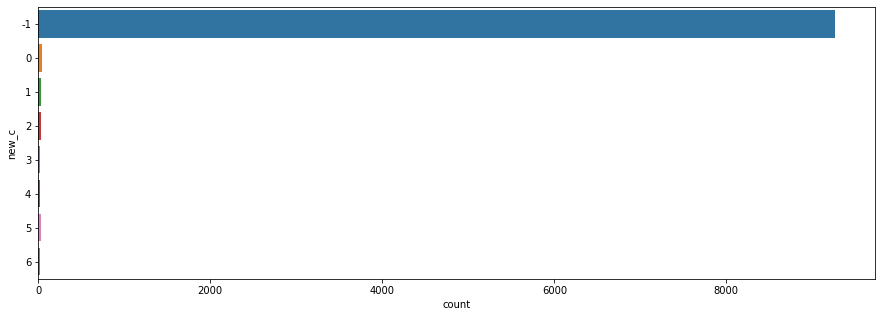

In [60]:
df['new_c'] = labels

fig = plt.figure(figsize=(15, 5))
sns.countplot(data=df, y='new_c')
plt.show()

Посмотрим на ключевые слова и категории.

In [61]:
for i in range(n_clusters_):
    print(f'Cluster {i}: ', end='')
    category_counts = df[df['new_c'] == i].category.value_counts()[:5]
    for name, count in zip(category_counts.index, category_counts):
        print(f'{name} - {count}, ', end='')
    print()

Cluster 0: food - 47, 
Cluster 1: transportation - 36, 
Cluster 2: utilities - 33, 
Cluster 3: personal - 25, recreation - 1, 
Cluster 4: housing - 24, utilities - 1, transportation - 1, 
Cluster 5: utilities - 36, housing - 1, 
Cluster 6: miscellaneous - 12, saving - 9, utilities - 3, personal - 1, 


In [62]:
df[df['new_c'] == 3].sample(10)

,entry,category,entry_new,new_w,new,new_c
3856,Bought a new shoe,personal,shoe,8,4,3
6540,shoes,personal,shoe,8,4,3
7387,Shoes - 3200,personal,shoe,8,4,3
6674,Shoe purchase,personal,shoe,8,4,3
3261,Shoes 45$,personal,shoe,8,4,3
33,New shoes 15$,personal,shoe,8,4,3
432,New shoes,personal,shoe,8,4,3
8639,Bought shoes,personal,shoe,8,4,3
1485,Shoes,personal,shoe,8,4,3
6381,New shoe,personal,shoe,8,4,3


Полностью аналогичные результаты. Попробуем другую метрику расстояния.

In [63]:
%%time
model = DBSCAN(eps=.1, min_samples=25, metric='jaccard', n_jobs=-1)
labels = model.fit_predict(X.toarray())

C:\Users\User\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


CPU times: total: 11min 11s
Wall time: 1min 34s


In [64]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

10

In [65]:
labels

array([-1, -1,  0, ..., -1, -1, -1], dtype=int64)

Посмотрим на отчёт по классификации.

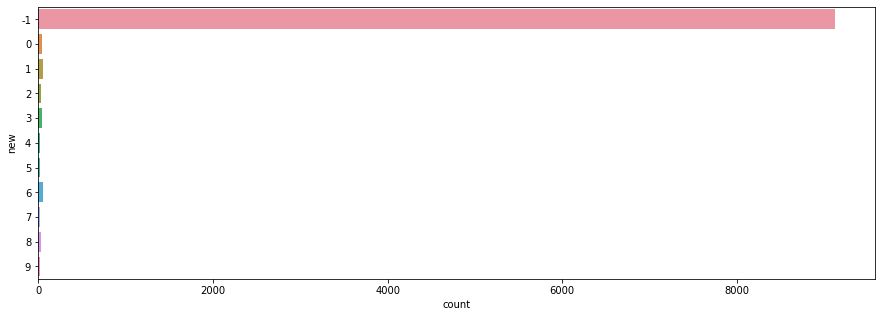

In [66]:
df['new'] = labels

fig = plt.figure(figsize=(15, 5))
sns.countplot(data=df, y='new')
plt.show()

Посмотрим на ключевые слова и категории.

In [67]:
for i in range(n_clusters_):
    print(f'Cluster {i}: ', end='')
    category_counts = df[df['new'] == i].category.value_counts()[:5]
    for name, count in zip(category_counts.index, category_counts):
        print(f'{name} - {count}, ', end='')
    print()

Cluster 0: food - 49, 
Cluster 1: utilities - 50, 
Cluster 2: transportation - 36, 
Cluster 3: utilities - 43, personal - 1, housing - 1, miscellaneous - 1, 
Cluster 4: personal - 25, recreation - 1, 
Cluster 5: housing - 24, utilities - 1, transportation - 1, 
Cluster 6: utilities - 46, food - 4, housing - 3, nonsense - 1, 
Cluster 7: transportation - 15, utilities - 11, 
Cluster 8: utilities - 32, 
Cluster 9: miscellaneous - 13, saving - 9, utilities - 3, personal - 1, 


In [68]:
df[df['new'] == 3].sample(10)

,entry,category,entry_new,new_w,new,new_c
565,phone bill 40,utilities,phone bill,7,3,-1
8695,Phone bills - Rs 6500,utilities,phone bill r,7,3,-1
2114,phone bills,utilities,phone bill,7,3,-1
5640,phone 10,utilities,phone,7,3,-1
7128,Phone bill 25,utilities,phone bill,7,3,-1
548,phone bill 35,utilities,phone bill,7,3,-1
34,Phone bill 45$,utilities,phone bill,7,3,-1
6861,Phone bill 65,utilities,phone bill,7,3,-1
8892,New Phone,miscellaneous,phone,7,3,-1
5865,phone bill $65,utilities,phone bill,7,3,-1


#### Выводы

В нашем случае, когда основная часть данных представляет собой плотное облако точек, даже такой мощный инструмент как DBSCAN смог лишь отбросив бОльшую часть данных как шум, кластеризовать оставшиеся.

## Заключение

В данной работе мы изучили популярные модели машинного обучения в задаче кластеризации.

Данные были предобработаны без отбрасывания категорий.

Были применены три стратегии векторизации при помощи **TfIdfVectorizer**'а. Отдельные слова, группы от 1 до 3 слов, н-граммы от 3 до 5 символов.

Также, для работы с некоторыми моделями был использован метод **TruncatedSVD** для понижения размерности до той степени, при которой объясняется по крайней мере 95% дисперсии исходных данных.

Были исследованы модели **K-means**, **Agglomerative Clustering** и **DBSCAN**.

Для модели **K-means** мы получили сильный дисбаланс классов, несмотря на применение техники понижения размерности. При этом ни в одной категории мы не наблюдали приличного совпадения кластеризации алгоритмом с кластеризацией пользователями.

Также был опробован метод поиска оптимального количества кластеров через исследование графика инерции, но и он не дал положительных результатов - график оказался практически линейным, без выраженных экстремумов.

Алгоритм **Agglomerate Clustering** позволяет увидеть визуальное распределение кластеров и пути их объединения с помощью дендрограмм и представляет интересный инструмент для исследования возможных кластеров.

В случае с нашими данными наиболее популярный способ поиска родительских кластеров для объединения `ward` не позволяет отделить бОльшую часть данных. Связь на основе максимальной дистанции между объединяемыми кластерами `complete` позволяет равномерно разделить данные, но полученные таким образом кластеры не имеют смысла с точки зрения "бизнес"-задачи.

Последним исследованным алгоитмом стал **DBSCAN**. Мы исследовали разные метрики расстояний с данным алгоритмом и он смог хорошо кластеризовать часть данных, но лишь при условии записи большинства данных в "шум".

На основе наблюдений полученных в ходе данной работы можно сделать вывод о том что представленные данные слишком плотно пересекаются и модели машинной кластеризации не подходят для решения задачи разделения без разметки данных вручную.

Также можно заключить что с представленными данными методы векторизации н-грамм из слов и отдельных слов не имеют принципиальной разницы, в то время как н-граммы из букв позволяют чуть лучше разделить данные.

Понижение размерности позволяет ускорить все модели, а также несколько улучишь некоторые (K-means) из них, но не позволяет достичь лучшего разделения данных.